In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_classification_report

In [2]:

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
dev_data = pd.read_csv('dev.csv')

In [3]:

def word2feature(seq, i):
    word, _ = seq[i]  # Extract the word from the tuple
    features = {
        "word.lower()": word.lower(),
        "word.isupper()": word.isupper(),
        "word.istitle()": word.istitle(),
        "word.isdigit()": word.isdigit(),
    }
    if i > 0:
        prev_word, _ = seq[i-1]  # Extract the previous word
        features.update({
            "prev_word.lower()": prev_word.lower(),
            "prev_word.isupper()": prev_word.isupper(),
            "prev_word.istitle()": prev_word.istitle(),
        })
    else:
        features["BOS"] = True  # Beginning of seq

    if i < len(seq) - 1:
        next_word, _ = seq[i+1]  # Extract the next word
        features.update({
            "next_word.lower()": next_word.lower(),
            "next_word.isupper()": next_word.isupper(),
            "next_word.istitle()": next_word.istitle(),
        })
    else:
        features["EOS"] = True  # End of seq

    return features


In [4]:
def get_sequences(data):
    sequences = []
    sequence = []
    for _, row in data.iterrows():
        word, tag = row['word'], row['tag']
        if not sequence and row['tag'] == 'I':
            if sequences and len(sequences[-1]) < 25:
                sequences[-1].append((word, tag))
            else:
                continue
        else:
            sequence.append((word, tag))
        
        if (len(sequence) == 20):
            sequences.append(sequence)
            sequence = []
    if sequence:
        sequences.append(sequence)
    return sequences
      

In [5]:
def prepare_data(sequences):
    X, y = [], []
    for seq in sequences:
        X.append([word2feature([word for word in seq], i) for i in range(len(seq))])
        y.append([tag for _, tag in seq])
    return X, y

In [6]:
# convert the data into sequences
train_sequences = get_sequences(train_data)
test_sequences = get_sequences(test_data)
dev_sequences = get_sequences(dev_data)

In [7]:
# prepare features and tag
X_train, y_train = prepare_data(train_sequences)
X_test, y_test = prepare_data(test_sequences)
X_dev, y_dev = prepare_data(dev_sequences)

In [8]:
# train the model CRF
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
)

crf.fit(X_train, y_train)

#save the model in pickle file
import pickle
with open('crf_model.pkl', 'wb') as model:
    pickle.dump(crf, model)

In [9]:
y_pred_test = crf.predict(X_test)
report = flat_classification_report(y_pred=y_pred_test, y_true=y_test)
print(report)

              precision    recall  f1-score   support

           B       0.68      0.54      0.60       451
           I       0.76      0.69      0.73       488
           O       0.91      0.95      0.93      3204

    accuracy                           0.87      4143
   macro avg       0.78      0.72      0.75      4143
weighted avg       0.86      0.87      0.87      4143



[[3031   94   79]
 [ 184  242   25]
 [ 130   21  337]]


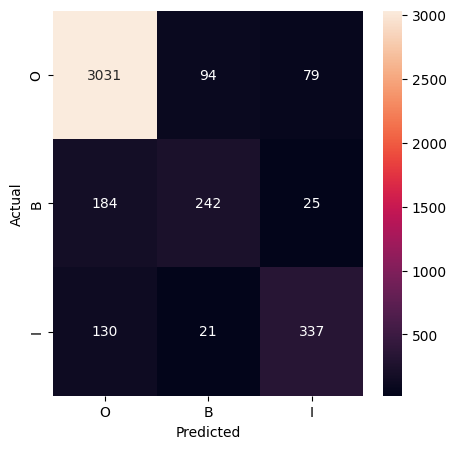

In [10]:
# plot the confusion matrix
labels = list(crf.classes_)
cm = confusion_matrix(np.concatenate(y_test), np.concatenate(y_pred_test), labels=labels)
print(cm)
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [11]:
y_pred_dev = crf.predict(X_dev) 
report = flat_classification_report(y_pred=y_pred_dev, y_true=y_dev)
print(report)

              precision    recall  f1-score   support

           B       0.71      0.54      0.62       409
           I       0.69      0.70      0.69       405
           O       0.90      0.93      0.92      2646

    accuracy                           0.86      3460
   macro avg       0.77      0.72      0.74      3460
weighted avg       0.86      0.86      0.86      3460



[[2473   70  103]
 [ 164  222   23]
 [ 103   20  282]]


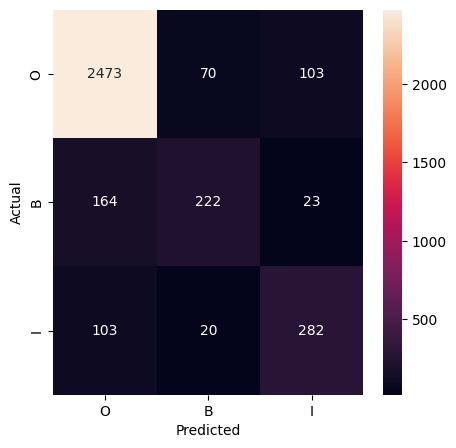

In [12]:
labels = list(crf.classes_)
cm = confusion_matrix(np.concatenate(y_dev), np.concatenate(y_pred_dev), labels=labels)
print(cm)
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [13]:


# Function to predict input sentence
def predict(sentence):
    # Tokenize the input sentence (splits words and punctuation separately)
    tokens = re.findall(r'\w+|[^\w\s]', sentence)
    
    # Create tuples with dummy tags
    token_tuples = [(word, 'O') for word in tokens]
    X = [word2feature(token_tuples, i) for i in range(len(tokens))]
    predicted_tags = crf.predict([X])[0]
    
    # Filter and format the output for tags 'B' and 'I'
    output = [

        f"{word}: {tag}"
        for word, tag in zip(tokens, predicted_tags)
        if tag in {'B', 'I'}
    ]
    if not output:
        return "No keywords found in the input sentence."
    else:
        print("Keywords in term of NLP are:")
    return "\n".join(output)

In [14]:
sentence = "NLP bridges the gap between human communication and computer understanding by analyzing and interpreting language data. Sentiment analysis, a popular application of NLP, helps companies understand customer opinions from reviews and social media posts."
print(predict(sentence))

Keywords in term of NLP are:
NLP: B
language: B
data: I
Sentiment: B
analysis: I
NLP: B


In [15]:
input= "The sentiment analysis model effectively classified the customer reviews using techniques like tokenization and part-of-speech tagging."
print(predict(input))

Keywords in term of NLP are:
sentiment: B
analysis: I
model: I
part: B
-: I
of: I
-: I
speech: I
tagging: I
